# ESO444-G084 (NFW)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
import math
import warnings
from IPython.display import display, Math
from scipy.stats import norm
from scipy.special import iv, kv
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#Membaca data kecepatan rotasi
gal = pd.read_excel('SPARC_RotCur.xlsx', sheet_name='Fisis')
d = pd.read_excel('SPARC_RotCur.xlsx', sheet_name='RotCur')
df = d.loc[d['ID'] == 'ESO444-G084'].reset_index(drop=True)
df

,ID,D,R,Vobs,e_Vobs,Vgas,Vdisk,Vbul,Sbdisk,Sbbul
0,ESO444-G084,4.83,0.26,18.3,1.80,4.59,8.31,0.0,31.29,0.0
1,ESO444-G084,4.83,0.77,35.3,3.00,11.55,14.79,0.0,10.44,0.0
2,ESO444-G084,4.83,1.29,47.8,4.63,16.45,14.54,0.0,3.29,0.0
3,ESO444-G084,4.83,1.81,52.8,1.26,19.03,13.66,0.0,1.03,0.0
4,ESO444-G084,4.83,2.32,58.0,3.11,20.09,12.28,0.0,0.34,0.0
5,ESO444-G084,4.83,3.39,63.1,1.35,17.39,9.97,0.0,0.03,0.0
6,ESO444-G084,4.83,4.44,62.7,7.36,14.45,8.53,0.0,0.00,0.0


In [4]:
rad = df['R'] #kpc
Vobs = df['Vobs'] #km/s
Vobs_err = df['e_Vobs'] #km/s
Vgas = df['Vgas'] #km/s
Vdisk = df['Vdisk'] #km/s

item_index = gal[gal['ID'] == 'ESO444-G084'].index[0]
r_star = gal.loc[item_index, 'Rdisk']
r_gas = 3*r_star
r_eff = gal.loc[item_index, 'Reff']
gal['Mstar'] = gal.L*10**9
gal['Mgas'] = 1.33*gal.MHI*10**9
M_star_a = gal.loc[item_index, 'Mstar']
M_gas_a = gal.loc[item_index, 'Mgas']

In [5]:
#MCMC
def main(p0, nwalkers, niter, ndim, ln_posterior, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=data)

    print("Running burn-in...")
    p0 = sampler.run_mcmc(p0, 500, progress=True) #500 iterasi pertama ditetapkan sebagai burn-in
    sampler.reset() #reset sampler sebelum melakukan iterasi utama

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

# Model Halo NFW

In [6]:
# Halo NFW
def VDM(V200, C200, r): # parameter bebas ditetapkan V200 dan C200
    # V200 dan C200 adalah kecepatan dan konsentrasi pada R200, rs adalah skala radius
    rs = V200 / (0.678 * C200) # kpc
    x = r/rs
    vh = V200 * np.sqrt((C200/x)*(np.log(1+x) - x/(1+x))/(np.log(1+C200) - C200/(1+C200)))
    return vh

#Fungsi model kecepatan rotasi total
def Vtot(ML_d, vDM, Vdisk, Vgas):
    #ML_d adalah mass to light ratio komponen disk
    return np.sqrt(vDM**2 + ML_d*(Vdisk**2) + Vgas*np.abs(Vgas))

In [7]:
#Likelihood
def ln_likelihood(theta, r, Vobs, Vdisk, Vgas, Vobs_err):
    V200, C200, ML_d = theta
    vDM = VDM(V200, C200, r)
    vtot = Vtot(ML_d, vDM, Vdisk, Vgas)
    lik = np.sum(-np.log(np.sqrt(2*math.pi)*Vobs_err) - ((Vobs - vtot)**2)/(2*(Vobs_err**2)))
    return lik

#Prior
def ln_prior(theta):
    V200, C200, ML_d = theta
    if 10.0 < V200 < 200.0: # km/s
        p1 = 1/190
    else:
        p1 = 0
    if 0.1 < C200 < 10:
        p2 = 1/9.9
    else:
        p2 = 0
    if ML_d > 0.0:
        p3 = norm.pdf(x=ML_d, loc=0.5, scale=(10**0.1 - 1)*0.5)
    else:
        p3 = 0
    return np.log(p1*p2*p3)

#Posterior
def ln_posterior(theta, r, Vobs, Vdisk, Vgas, Vobs_err):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf      
    return lp + ln_likelihood(theta, r, Vobs, Vdisk, Vgas, Vobs_err)

## MCMC NFW

In [8]:
#Menjalankan MCMC
nwalkers = 50 #number of walkers
niter = 30000 #number of iterations
init_param = np.array([81.64, 5.67, 0.45]) #V200, C200, M/L ambil semuanya secara sembarang dalam rentang prior
ndim = len(init_param) #number of dimension
p0 = [np.array(init_param) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)] #methodology of stepping from one place to a grid to the next

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,ln_posterior,(rad, Vobs, Vdisk, Vgas, Vobs_err)) #run MCMC

Running burn-in...


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.61it/s]


Running production...


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [46:40<00:00, 10.71it/s]


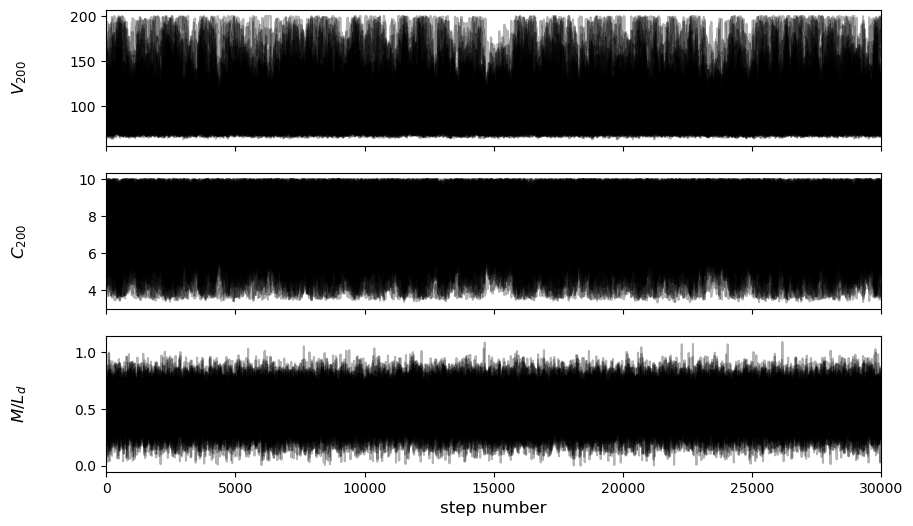

In [48]:
#Membuat plot masing-masing parameter (MCMC chains) untuk mengecek konvergensi
fig, axes = plt.subplots(ndim, figsize=(10, 6), sharex=True)
samples = sampler.get_chain()
labels = [r"$V_{200}$", r"$C_{200}$", r"$M/L_d$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=12)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontsize=12);
plt.savefig('Trace plot {} (NFW).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi=300)

In [49]:
# Flat: concatenating the samples from each walker in the chain
# Discard: menghapus X sampel (flattened) pertama
# Thin: mengambil sampel kelipatan ke-X saja (untuk merampingkan sampel dan menghemat ukuran sampel)
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
np.savetxt("Flat samples {} (NFW).txt".format(df['ID'][0]), np.c_[flat_samples[:, 0],flat_samples[:, 1],flat_samples[:, 2]])

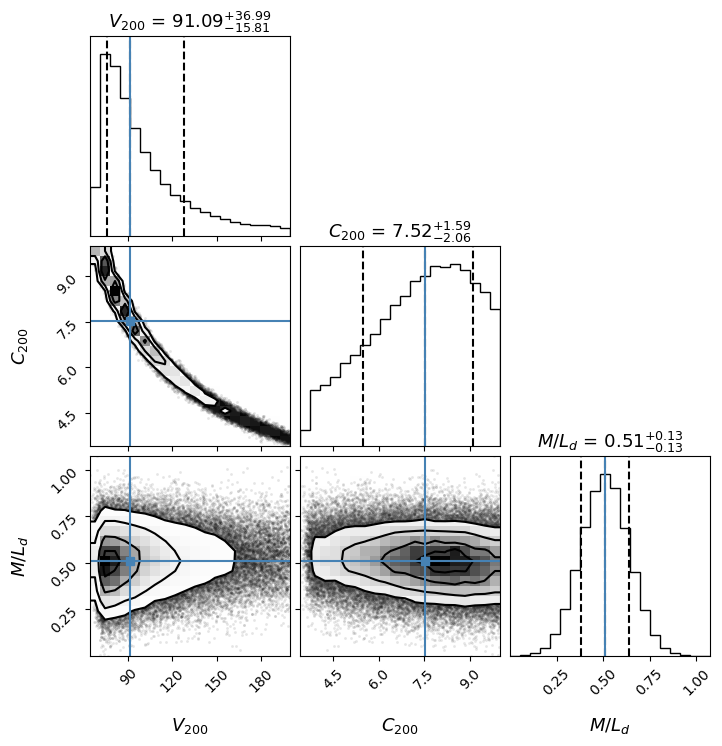

In [8]:
#Membuat corner plot
#Menyimpan nilai best-fit parameter hasil MCMC
flat_samples = np.loadtxt("Flat samples {} (NFW).txt".format(df['ID'][0]))
labels = [r"$V_{200}$", r"$C_{200}$", r"$M/L_d$"]

V200 = np.median(flat_samples[:, 0])
C200 = np.median(flat_samples[:, 1])
ML_d = np.median(flat_samples[:, 2])

fig = corner.corner(flat_samples,show_titles=True,title_kwargs={"fontsize":13},labels=labels,label_kwargs={"fontsize":13},plot_datapoints=True,truths=[V200,C200,ML_d],quantiles=[0.16, 0.5, 0.84],dpi=200)
plt.savefig('Corner plot {} (NFW).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi=300)

In [9]:
#Menghitung kecepatan komponen halo DM dan kecepatan total menggunakan nilai best-fit
vDM = VDM(V200, C200, rad)
vtot = Vtot(ML_d, vDM, Vdisk, Vgas)

In [10]:
#Menuliskan nilai best-fit parameter hasil MCMC dan reduced chi squared
labels2 = [r'V_{200}', r'C_{200}', r'M/L_d']
ndim = 3
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels2[i])
    display(Math(txt))

rsn = V200 / (0.678 * C200)
trsn = "\mathrm r_{{s,NFW}} = {0:.3f} \, \\textrm{{kpc}}".format(rsn)
r200n = C200*rsn
tr200n = "\mathrm r_{{200,NFW}} = {0:.3f} \, \\textrm{{kpc}}".format(r200n)
H0 = 67.8
G = 4.3e-6
m200n = np.log10(V200 ** 2 * r200n / G)
tm200n = "$\log M_{{200,\mathrm{{NFW}}}} (\mathrm{{M_{{\odot}}}}) = {0:.3f}$".format(m200n)
display(Math(trsn))
display(Math(tr200n))
display(Math(tm200n))

chisq = 0.
for i in range(len(rad)):
    chisq = chisq + (((Vobs[i] - vtot[i])**2)/(Vobs_err[i])**2)

red_chisq = chisq/(len(rad) - ndim) #reduced chi squared
txt2 = "\mathrm\chi_{{\\nu}}^2 = {0:.3f}".format(red_chisq)
display(Math(txt2))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [53]:
print("Mean autocorrelation time (NFW): {0:.4f}".format(np.mean(sampler.get_autocorr_time())))

Mean autocorrelation time (NFW): 174.4726


In [54]:
print("Mean acceptance fraction (NFW): {0:.4f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction (NFW): 0.4912


In [11]:
#Komponen kecepatan disk adalah akar dari (ML_d * (Vdisk**2)), dari Li et al. 2020
Vdisk_f = []
for i in range(len(rad)):
    vdisk_f = np.sqrt(ML_d) * (Vdisk[i])
    Vdisk_f.append(vdisk_f)
np.savetxt('Mass model {} (NFW).txt'.format(df['ID'][0]), np.c_[rad,Vobs,Vobs_err,Vgas,Vdisk_f,vDM,vtot], fmt='% 1.3f', header='R     Vobs    eVobs  Vgas    Vdisk   VDM     Vtot')

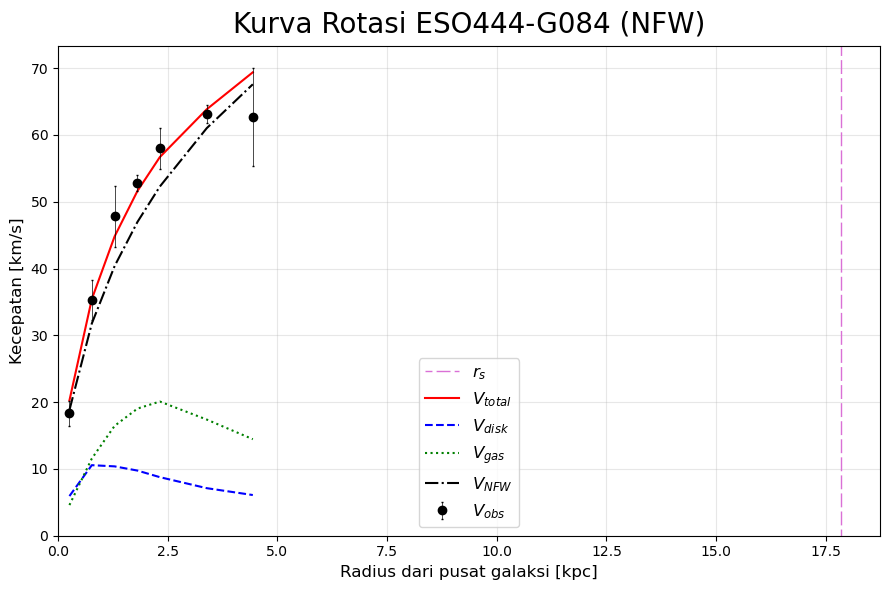

In [12]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
plt.axvline(x = rsn, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_s$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{NFW}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kurva Rotasi {} (NFW)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi {} (NFW).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 300)
plt.show()

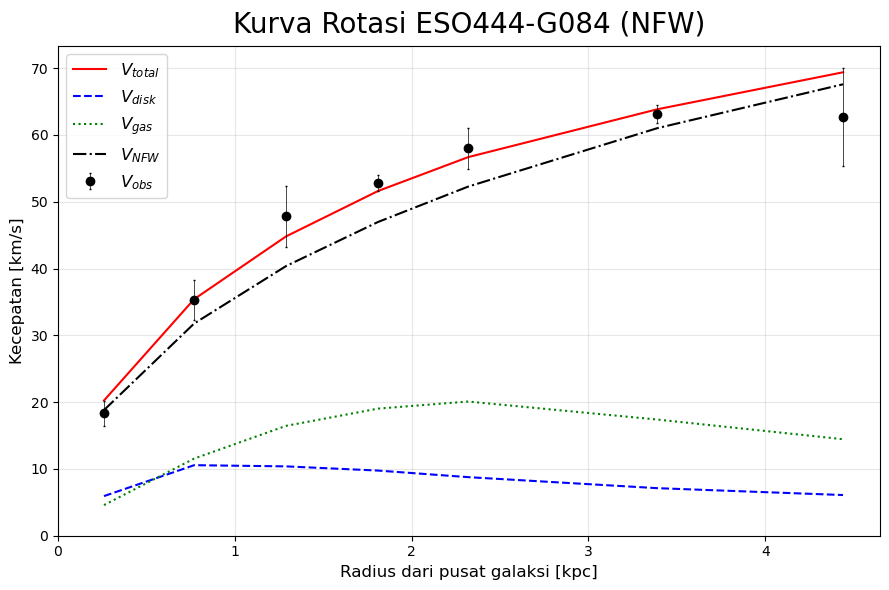

In [13]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{NFW}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kurva Rotasi {} (NFW)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi {} (NFW) 2.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 300)
plt.show()

In [14]:
rsmooth = np.linspace(df['R'][0], df['R'][df['R'].argmax()], 1000)
vDM = VDM(V200, C200, rsmooth)

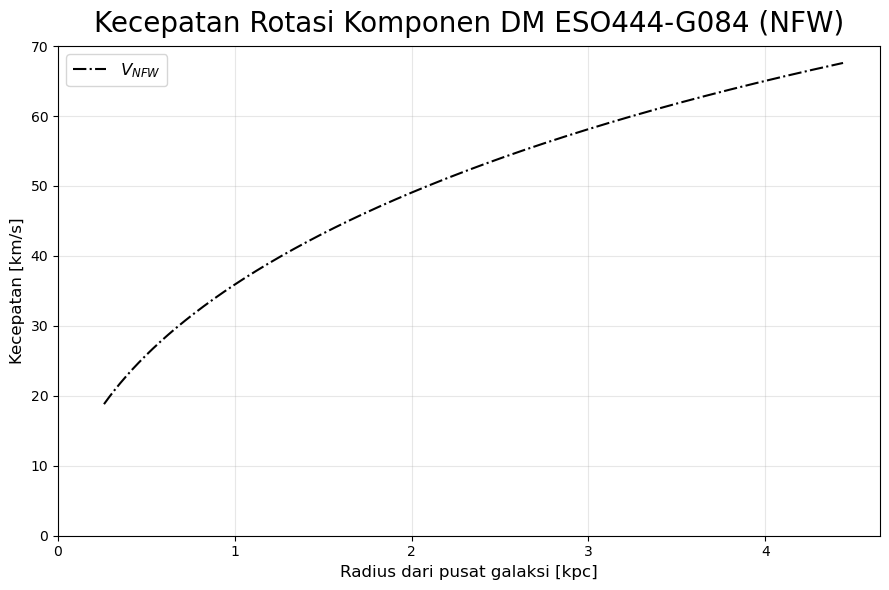

In [15]:
#Membuat plot kurva rotasi DM
plt.figure(figsize=(9,6))
#plt.axvline(x = rsn, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_s$')
plt.plot(rsmooth, vDM, label = '$V_{NFW}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kecepatan Rotasi Komponen DM {} (NFW)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kecepatan Rotasi Komponen DM {} (NFW).jpg'.format(df['ID'][0]), format = 'jpg', dpi = 150)
plt.show()

# 1sigma posterior spread (NFW)

In [16]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        vDM = VDM(i[0], i[1], rad)
        vtot = Vtot(i[2], vDM, Vdisk, Vgas)
        models.append(vtot)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(10000,flat_samples)

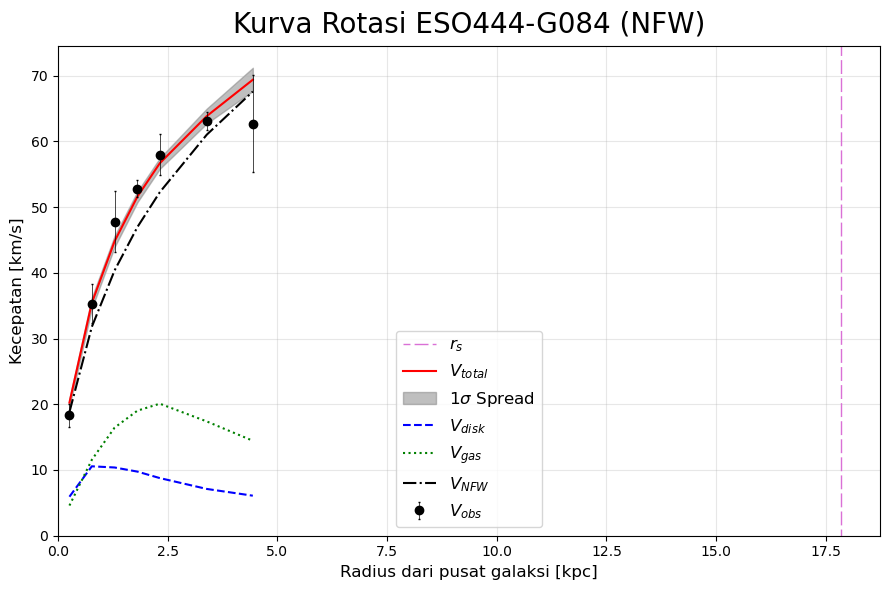

In [17]:
#Membuat plot kurva rotasi dengan 1sigma posterior spread
vDM = VDM(V200, C200, rad)
plt.figure(figsize=(9,6))
plt.axvline(x = rsn, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_s$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.fill_between(rad,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Spread')
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{NFW}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kurva Rotasi {} (NFW)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi {} 1sigma (NFW).jpg'.format(df['ID'][0]), format = 'jpg', dpi = 150)
plt.show()

## Maximum A Posteriori (NFW)

In [62]:
lnprob_samples = sampler.get_log_prob(discard=500, thin=15, flat=True)
np.savetxt("Lnprob samples {} (NFW).txt".format(df['ID'][0]), np.c_[lnprob_samples[:]])

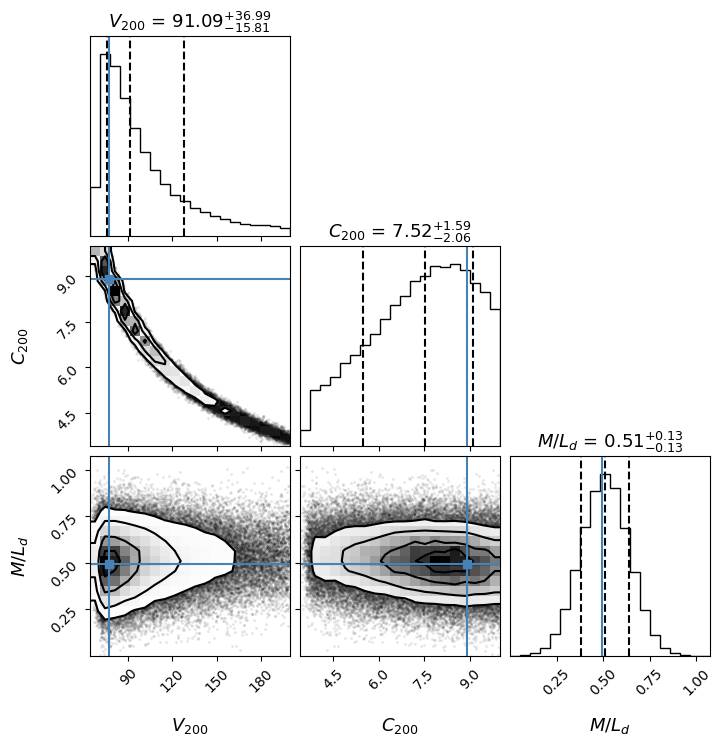

In [18]:
lnprob_samples = np.loadtxt("Lnprob samples {} (NFW).txt".format(df['ID'][0]))
theta_max = flat_samples[np.argmax(lnprob_samples)]

#Menyimpan nilai best-fit parameter hasil MCMC
V200 = theta_max[0]
C200 = theta_max[1]
ML_d = theta_max[2]

fig = corner.corner(flat_samples,show_titles=True,title_kwargs={"fontsize":13},labels=labels,label_kwargs={"fontsize":13},plot_datapoints=True,truths=[V200,C200,ML_d],quantiles=[0.16, 0.5, 0.84],dpi=200)
plt.savefig('Corner plot MAP {} (NFW).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi=300)

In [19]:
#Menghitung kecepatan komponen halo DM dan kecepatan total menggunakan nilai best-fit
vDM = VDM(V200, C200, rad)
vtot = Vtot(ML_d, vDM, Vdisk, Vgas)

In [20]:
#Menuliskan nilai best-fit parameter hasil MCMC dan reduced chi squared
for i in range(ndim):
    std = np.std(flat_samples[:, i])
    txt = "\mathrm{{{2}}} = {0:.3f} \pm {1:.3f}"
    txt = txt.format(theta_max[i], std, labels2[i])
    display(Math(txt))

rsn = V200 / (0.678 * C200)
trsn = "\mathrm r_{{s,NFW}} = {0:.3f} \, \\textrm{{kpc}}".format(rsn)
r200n = C200*rsn
tr200n = "\mathrm r_{{200,NFW}} = {0:.3f} \, \\textrm{{kpc}}".format(r200n)
H0 = 67.8
G = 4.3e-6
m200n = np.log10(V200 ** 2 * r200n / G)
tm200n = "$\log M_{{200,\mathrm{{NFW}}}} (\mathrm{{M_{{\odot}}}}) = {0:.3f}$".format(m200n)
display(Math(trsn))
display(Math(tr200n))
display(Math(tm200n))

chisq = 0.
for i in range(len(rad)):
    chisq = chisq + (((Vobs[i] - vtot[i])**2)/(Vobs_err[i])**2)

red_chisq = chisq/(len(rad) - ndim) #reduced chi squared
txt2 = "\mathrm\chi_{{\\nu}}^2 = {0:.3f}".format(red_chisq)
display(Math(txt2))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
# Find the index of the maximum log-probability
max_lnprob_index = np.argmax(lnprob_samples)

# Calculate the maximum likelihood (exponent of the maximum log-probability)
max_likelihood = np.exp(lnprob_samples[max_lnprob_index])

# Number of parameters in the model
k = len(theta_max)

# Number of data points (assuming `n` is provided, e.g., `n` is the length of the data)
n = len(df)

# Calculate BIC
bic = k * np.log(n) - 2 * lnprob_samples[max_lnprob_index]

print("ml:", max_likelihood)
print("BIC:", bic)

np.savetxt('BIC {} (NFW).txt'.format(df['ID'][0]), np.c_[bic], fmt='% 1.3f', header='BIC')

ml: 5.076855977538736e-10
BIC: 48.640047971182554


In [22]:
bic1 = chisq/2 +k*np.log(n)
bic1

7.509767237930096

In [23]:
#Komponen kecepatan disk adalah akar dari (ML_d * (Vdisk**2)), dari Li et al. 2020
Vdisk_f = []
for i in range(len(rad)):
    vdisk_f = np.sqrt(ML_d) * (Vdisk[i])
    Vdisk_f.append(vdisk_f)
np.savetxt('Mass model MAP {} (NFW).txt'.format(df['ID'][0]), np.c_[rad,Vobs,Vobs_err,Vgas,Vdisk_f,vDM,vtot], fmt='% 1.3f', header='R     Vobs    eVobs  Vgas    Vdisk   VDM     Vtot')

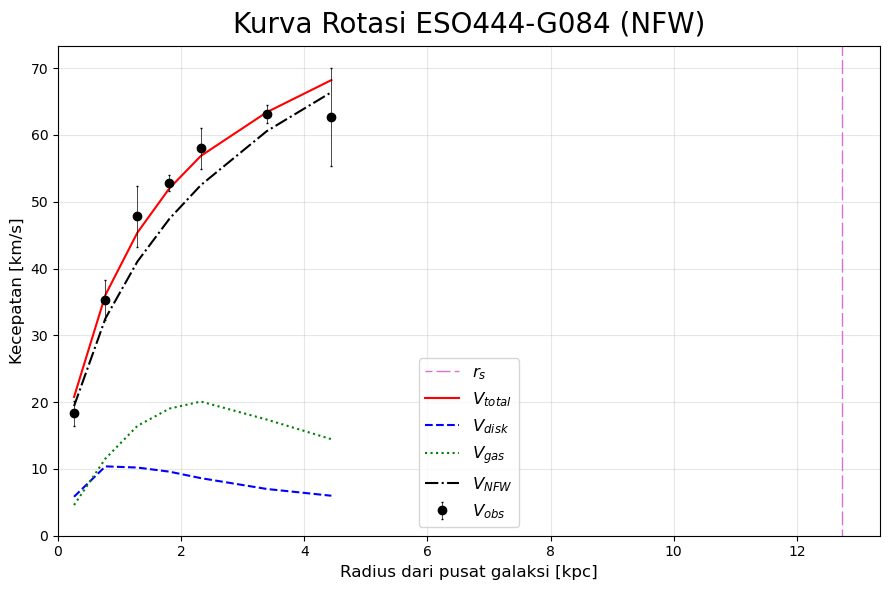

In [24]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
plt.axvline(x = rsn, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_s$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{NFW}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kurva Rotasi {} (NFW)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi MAP {} (NFW).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 300)
plt.show()

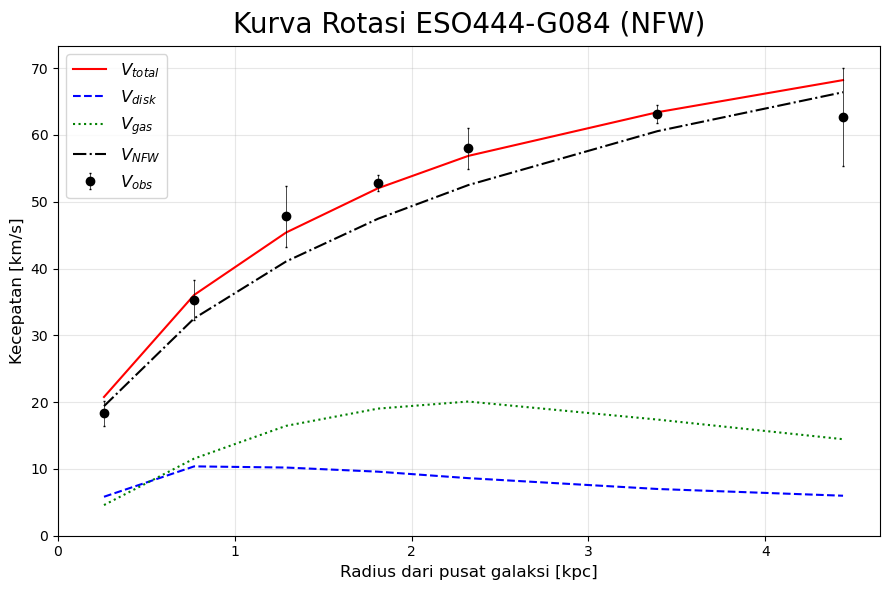

In [25]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{NFW}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kurva Rotasi {} (NFW)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi MAP {} (NFW) 2.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 300)
plt.show()

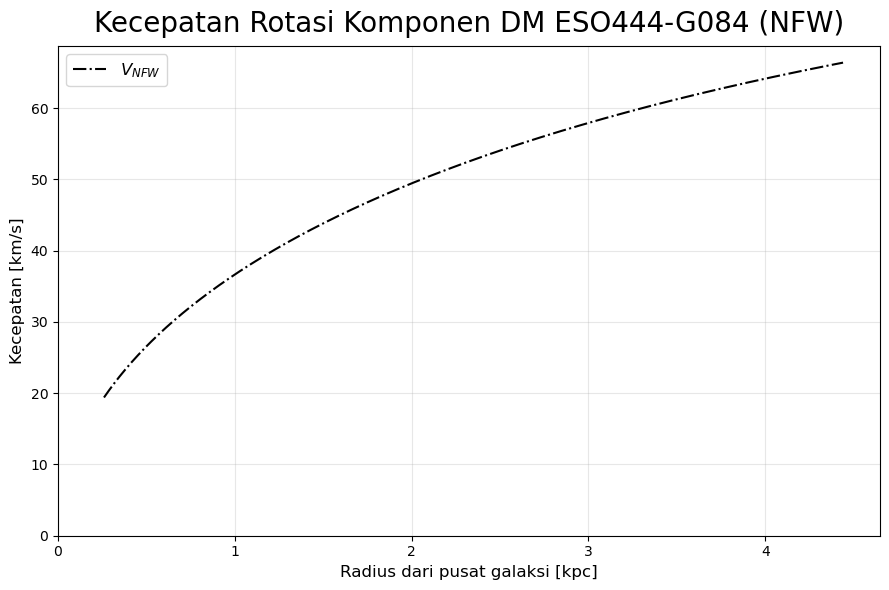

In [26]:
#Membuat plot kurva rotasi DM
vDM = VDM(V200, C200, rsmooth)
plt.figure(figsize=(9,6))
#plt.axvline(x = rsn, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_s$')
plt.plot(rsmooth, vDM, label = '$V_{NFW}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kecepatan Rotasi Komponen DM {} (NFW)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kecepatan Rotasi Komponen DM MAP {} (NFW).jpg'.format(df['ID'][0]), format = 'jpg', dpi = 150)
plt.show()

## Fraksi Dark Matter

In [27]:
# Interpolasi Kubik Profil Kecepatan
c1 = CubicSpline(rad, vtot)
c2= CubicSpline(rad, Vdisk_f)
c3 = CubicSpline(rad, Vgas)
c4 = CubicSpline(rsmooth, vDM)

# Memperoleh nilai kecepatan di radius efektif
total = c1(r_eff)
bintang = c2(r_eff)
gas = c3(r_eff)
dm = c4(r_eff)

# Print
print(f"At x = {r_eff}, total = {total}")
print(f"At x = {r_eff}, bintang = {bintang}")
print(f"At x = {r_eff}, gas = {gas}")
print(f"At x = {r_eff}, dm = {dm}")

At x = 0.75, total = 35.59492059251238
At x = 0.75, bintang = 10.327359754419726
At x = 0.75, gas = 11.314450406848927
At x = 0.75, dm = 32.14338985796642


In [28]:
#Massa Baryon
G = 4.3e-6
Mstar = ML_d*(M_star_a)*(1-(1+r_eff/r_star)*np.exp(-r_eff/r_star))
Mgas = (M_gas_a)*(1-(1+r_eff/r_gas)*np.exp(-r_eff/r_gas))
M_bar = Mstar + Mgas
M_bar

35575677.42318353

In [29]:
#Massa DM
M_dm = (dm**2 * r_eff)/G
M_dm

180208868.2955613

In [30]:
#Fraksi DM
frac = M_dm/(M_bar+M_dm)
frac

0.8351333395786688

In [31]:
# Use the spline interpolator to get the interpolated y-value
r_opt = (3.2/1.69)*r_eff
total1 = c1(r_opt)
bintang1 = c2(r_opt)
gas1 = c3(r_opt)
dm1 = c4(r_opt)

# Print or use the result as needed
print(f"At x = {r_opt}, total = {total1}")
print(f"At x = {r_opt}, bintang = {bintang1}")
print(f"At x = {r_opt}, gas = {gas1}")
print(f"At x = {r_opt}, dm = {dm1}")

At x = 1.4201183431952664, total = 47.23223909253726
At x = 1.4201183431952664, bintang = 10.042336884196729
At x = 1.4201183431952664, gas = 17.282665125456983
At x = 1.4201183431952664, dm = 42.81324347716791


In [32]:
Mstar1 = ML_d*(M_star_a)*(1-(1+r_opt/r_star)*np.exp(-r_opt/r_star))
Mgas1 = (M_gas_a)*(1-(1+r_opt/r_gas)*np.exp(-r_opt/r_gas))
M_bar1 = Mstar1 + Mgas1
M_bar1

77825874.3749573

In [33]:
M_dm1 = (dm1**2 * r_opt)/G
M_dm1

605358079.1089343

In [34]:
frac1 = M_dm1/(M_bar1+M_dm1)
frac1

0.8860835738631084

In [35]:
np.savetxt('Parameter {} (NFW).txt'.format(df['ID'][0]), np.c_[rsn, r200n, m200n, red_chisq, frac, frac1], fmt='% 1.3f', header='rs    r200    m200    rcs    frac   frac_o')

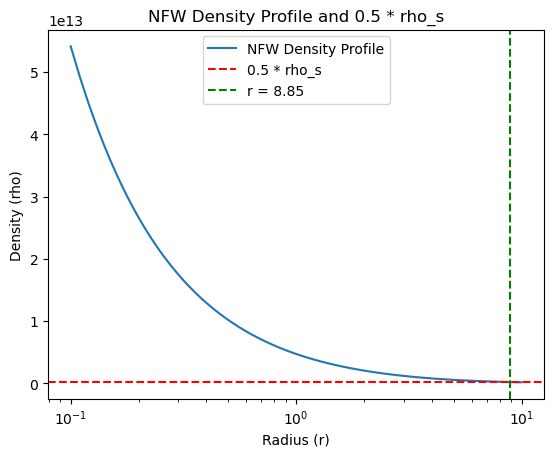

In [36]:
# Correct calculation of rho_s
rho_s = (200 / 3) * (C200 ** 3) * (1.2744e7) / (np.log(1 + C200) - C200 / (1 + C200))

# Define the radius array
r = np.linspace(0.1, 10, 1000)  # Adjust rad.max() accordingly

# Calculate rho_nfw
rho_nfw = rho_s / ((r / rsn) * (1 + (r / rsn)) ** 2)

# Find the radius where rho_nfw = 0.5 * rho_s
r_half_rho_s = np.interp(0.5 * rho_s, rho_nfw[::-1], r[::-1])

# Plot the NFW density profile
plt.plot(r, rho_nfw, label='NFW Density Profile')
plt.axhline(0.5 * rho_s, color='r', linestyle='--', label='0.5 * rho_s')
plt.axvline(r_half_rho_s, color='g', linestyle='--', label=f'r = {r_half_rho_s:.2f}')

# Add labels and legend
plt.xlabel('Radius (r)')
plt.ylabel('Density (rho)')
# plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('NFW Density Profile and 0.5 * rho_s')
plt.show()